## 2. Введение в анализ данных

### i. Импорты

In [4]:
import pandas as pd
import numpy as np
import sklearn  
import lightgbm as lgb
import scipy 
import statsmodels as sm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.tree import DecisionTreeRegressor 

### ii. Чтение данных из файла

In [5]:
df = pd.read_json("data/train.json")

### iii. Каков размер (количество строк и столбцов) ваших данных?

In [6]:
print(f"Размерность датафрейма: {df.shape}")

Размерность датафрейма: (49352, 15)


### iv. Вывод столбцов и определение целевого 

In [7]:
list(df.columns)

['bathrooms',
 'bedrooms',
 'building_id',
 'created',
 'description',
 'display_address',
 'features',
 'latitude',
 'listing_id',
 'longitude',
 'manager_id',
 'photos',
 'price',
 'street_address',
 'interest_level']

Поскольку нам нужно предсказать цену, то целевым столбцом является 'price'

### v. Быстрый анализ данных: используйте методы info() , describe() , corr() . Объясните результаты. Есть ли пустые столбцы?

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 49352 entries, 4 to 124009
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   bathrooms        49352 non-null  float64
 1   bedrooms         49352 non-null  int64  
 2   building_id      49352 non-null  object 
 3   created          49352 non-null  object 
 4   description      49352 non-null  object 
 5   display_address  49352 non-null  object 
 6   features         49352 non-null  object 
 7   latitude         49352 non-null  float64
 8   listing_id       49352 non-null  int64  
 9   longitude        49352 non-null  float64
 10  manager_id       49352 non-null  object 
 11  photos           49352 non-null  object 
 12  price            49352 non-null  int64  
 13  street_address   49352 non-null  object 
 14  interest_level   49352 non-null  object 
dtypes: float64(3), int64(3), object(9)
memory usage: 6.0+ MB


In [9]:
df.describe()

,bathrooms,bedrooms,latitude,listing_id,longitude,price
count,49352.00000,49352.000000,49352.000000,4.935200e+04,49352.000000,4.935200e+04
mean,1.21218,1.541640,40.741545,7.024055e+06,-73.955716,3.830174e+03
std,0.50142,1.115018,0.638535,1.262746e+05,1.177912,2.206687e+04
min,0.00000,0.000000,0.000000,6.811957e+06,-118.271000,4.300000e+01
25%,1.00000,1.000000,40.728300,6.915888e+06,-73.991700,2.500000e+03
50%,1.00000,1.000000,40.751800,7.021070e+06,-73.977900,3.150000e+03
75%,1.00000,2.000000,40.774300,7.128733e+06,-73.954800,4.100000e+03
max,10.00000,8.000000,44.883500,7.753784e+06,0.000000,4.490000e+06


In [10]:
df.corr(numeric_only=True)

,bathrooms,bedrooms,latitude,listing_id,longitude,price
bathrooms,1.000000,0.533446,-0.009657,0.000776,0.010393,0.069661
bedrooms,0.533446,1.000000,-0.004745,0.011968,0.006892,0.051788
latitude,-0.009657,-0.004745,1.000000,0.001712,-0.966807,-0.000707
listing_id,0.000776,0.011968,0.001712,1.000000,-0.000907,0.008090
longitude,0.010393,0.006892,-0.966807,-0.000907,1.000000,-0.000087
price,0.069661,0.051788,-0.000707,0.008090,-0.000087,1.000000


В результате быстрого анализа данных было выявлено несколько особенностей: пропуски в данных отсутствуют, простые числовые признаки слабо объясняют целевую переменную, поэтому для прогноза стоит дополнительно обработать текстовые данные

### vi. Очистка данных

In [11]:
df = df[['bathrooms', 'bedrooms', 'interest_level', 'price']]

In [12]:
df.head()

,bathrooms,bedrooms,interest_level,price
4,1.0,1,medium,2400
6,1.0,2,low,3800
9,1.0,2,medium,3495
10,1.5,3,medium,3000
15,1.0,0,low,2795


## 3. Статистический анализ данных

### iii.Целевой анализ

#### a. Постройте гистограмму, чтобы понять распределение цели. Всё ли понятно?

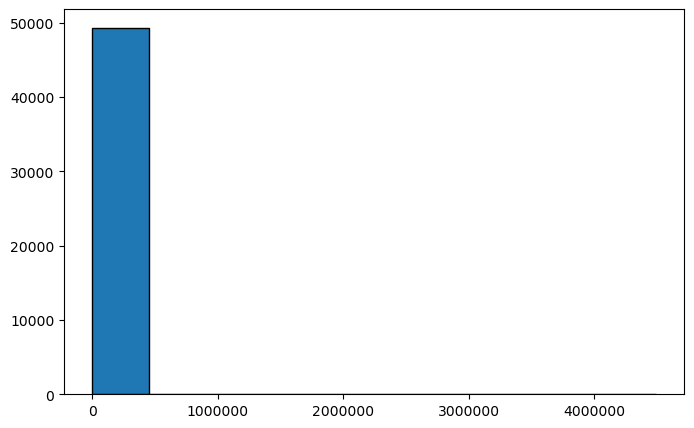

In [13]:
plt.figure(figsize=(8, 5))
plt.hist(df['price'], edgecolor='black')
ax = plt.gca()
ax.ticklabel_format(style='plain', axis='x', useOffset=False)
plt.show()

#### b. Следующий шаг — boxplot(). Что вы можете сказать о целевой функции? Есть ли выбросы?

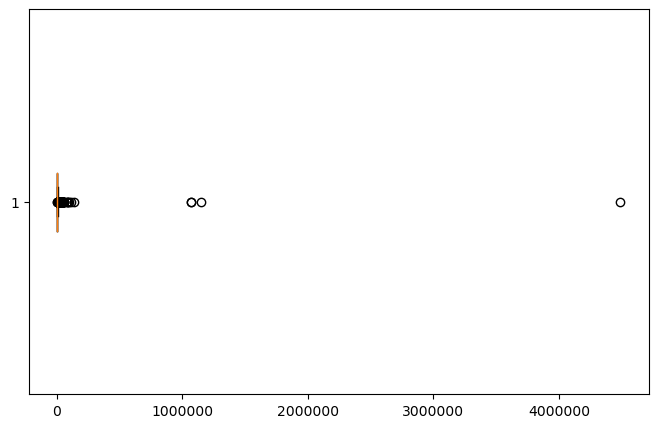

In [14]:
plt.figure(figsize=(8, 5))
plt.boxplot(df['price'], vert=False)
ax = plt.gca()
ax.ticklabel_format(style='plain', axis='x', useOffset=False)
plt.show()

#### c. Удалите из целевого столбца строки, находящиеся за пределами 1 и 99 процентилей.

In [15]:
lower_bound = df['price'].quantile(0.01)
upper_bound = df['price'].quantile(0.99)

In [16]:
df = df[(df['price'] >= lower_bound) & (df['price'] <= upper_bound)]

#### d. Постройте ещё одну гистограмму для цены. Объясните результат.

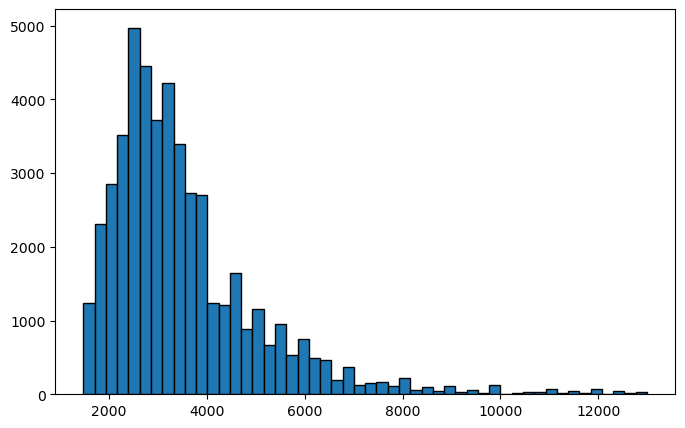

In [17]:
plt.figure(figsize=(8, 5))
plt.hist(df['price'], bins = 50,  edgecolor='black')
plt.show()

### iv. Анализ характеристик

#### a. Какой тип столбца «interest_level»?

In [18]:
df['interest_level'].info()

<class 'pandas.core.series.Series'>
Index: 48379 entries, 4 to 124009
Series name: interest_level
Non-Null Count  Dtype 
--------------  ----- 
48379 non-null  object
dtypes: object(1)
memory usage: 755.9+ KB


#### b. Выведите значения в этом столбце. Сколько записей содержит каждое значение?

In [19]:
df['interest_level']

4         medium
6            low
9         medium
10        medium
15           low
           ...  
124000       low
124002    medium
124004    medium
124008    medium
124009      high
Name: interest_level, Length: 48379, dtype: object

In [20]:
df['interest_level'].value_counts()  

interest_level
low       33697
medium    11116
high       3566
Name: count, dtype: int64

#### c. Закодируйте эти значения. Например, вы можете заменить каждое значение на 0, 1 или 2.

In [21]:
encoder = LabelEncoder()
df['interest_level'] = encoder.fit_transform(df['interest_level'])

#### d. Постройте гистограммы для признаков «ванные комнаты» и «спальни». Есть ли выбросы?

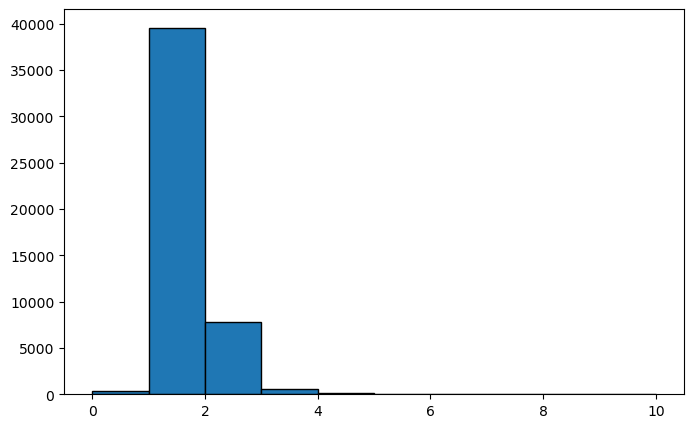

In [22]:
plt.figure(figsize=(8, 5))
plt.hist(df['bathrooms'],  edgecolor='black')
plt.show()

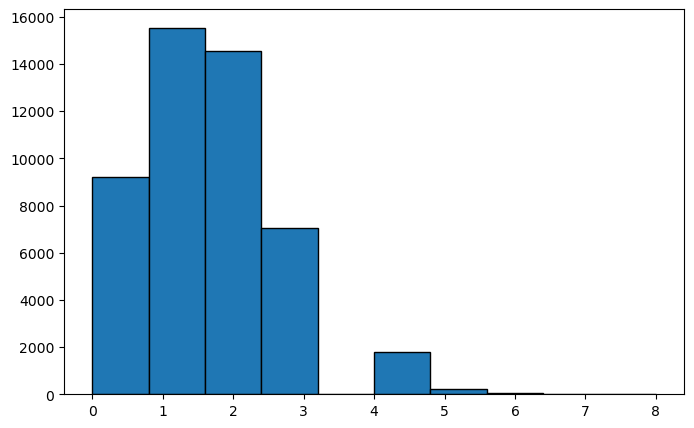

In [23]:
plt.figure(figsize=(8, 5))
plt.hist(df['bedrooms'],  edgecolor='black')
plt.show()

Присутствует небольшое количество выбросов на обеих гистограммах

### v. Комплексный анализ

#### a. Постройте корреляционную матрицу, чтобы понять взаимосвязь между признаками и целевым объектом. Постройте тепловую карту для корреляционной матрицы. Есть ли корреляция?

In [24]:
corr_matrix = df.corr()  
corr_matrix

,bathrooms,bedrooms,interest_level,price
bathrooms,1.000000,0.517574,-0.006578,0.671943
bedrooms,0.517574,1.000000,0.028754,0.545948
interest_level,-0.006578,0.028754,1.000000,-0.033239
price,0.671943,0.545948,-0.033239,1.000000


Максимальная корреляция с ванными комнатами

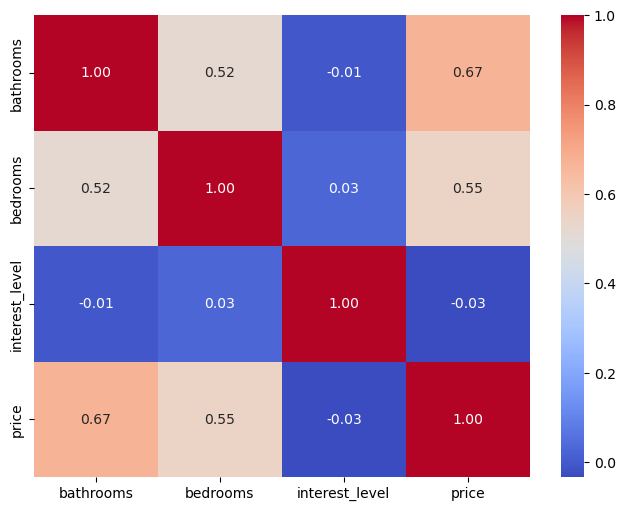

In [25]:
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.show()

#### b. Постройте диаграмму рассеяния для визуализации корреляции между признаками и целевым значением. Необходимо получить три графика, где ось X соответствует целевому значению, а ось Y — признаку.

In [26]:
features = ['bathrooms', 'bedrooms', 'interest_level']

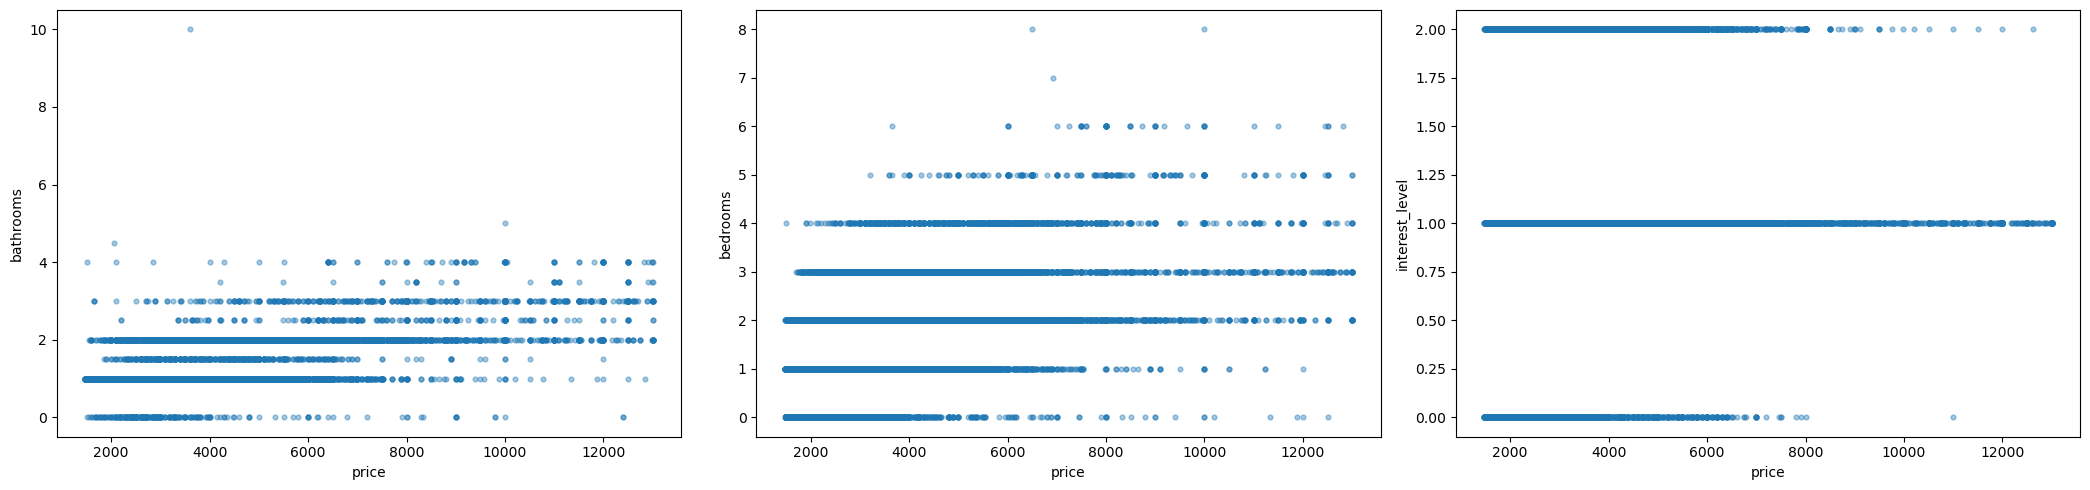

In [27]:
fig, axes = plt.subplots(1, 3, figsize=(21, 5)) 

for ax, feature in zip(axes, features):
    ax.scatter(df['price'], df[feature], alpha=0.4, s=12)
    ax.set_xlabel('price')
    ax.set_ylabel(feature)

plt.tight_layout()
plt.show()


## 4. Создание функции

#### i-ii. Этот шаг очень обширен. Вы можете создать любое количество признаков. Например, можно добавить три новых признака, возведённых в квадрат: «bathrooms_squared», «bedrooms_squared», «interest_level_squared». Постройте матрицу корреляции с новыми признаками. Коррелируют ли новые признаки с целевой матрицей сильнее, чем базовые? Для обучения модели мы не будем использовать ваши новые признаки. Запомните этот пример и используйте его в лекции 2. Для обучения модели мы рассмотрим только признаки «ванные комнаты» и «спальни».

In [28]:
features = ['bathrooms', 'bedrooms', 'interest_level']
for col in features:
    df[col + '_squared'] = df[col] ** 2

In [29]:
corr_matrix_new = df.corr()  
corr_matrix_new

,bathrooms,bedrooms,interest_level,price,bathrooms_squared,bedrooms_squared,interest_level_squared
bathrooms,1.000000,0.517574,-0.006578,0.671943,0.956023,0.548760,-0.025866
bedrooms,0.517574,1.000000,0.028754,0.545948,0.478817,0.928277,0.042426
interest_level,-0.006578,0.028754,1.000000,-0.033239,-0.012424,0.027602,0.950839
price,0.671943,0.545948,-0.033239,1.000000,0.648486,0.543406,-0.092995
bathrooms_squared,0.956023,0.478817,-0.012424,0.648486,1.000000,0.522227,-0.032822
bedrooms_squared,0.548760,0.928277,0.027602,0.543406,0.522227,1.000000,0.040017
interest_level_squared,-0.025866,0.042426,0.950839,-0.092995,-0.032822,0.040017,1.000000


#### iii-iv. Прочтите эту информацию Sklearn о PolynomialFeatures. Чтобы использовать PolynomialFeatures, нам сначала нужно разделить данные на обучающую и тестовую выборки. Мы уже сделали это за вас, пожалуйста, ознакомьтесь с обучающими и тестовыми данными.

In [30]:
test_df = pd.read_json("data/test.json")

In [31]:
test_df = test_df[['bathrooms', 'bedrooms', 'price']].copy()

In [32]:
for col in test_df.select_dtypes(include='number').columns:
    lower_bound = test_df[col].quantile(0.01)
    upper_bound = test_df[col].quantile(0.99)
    test_df = test_df[(test_df[col] > lower_bound) & (test_df[col] < upper_bound)]

In [33]:
train_df = df[['bathrooms', 'bedrooms', 'price']].copy()

In [34]:
X_train = train_df.drop(columns=['price'])
y_train = train_df['price']

X_test = test_df.drop(columns=['price'])
y_test = test_df['price']

#### v. Инициализируйте PolynomialFeatures() со степенью 10.

In [35]:
poly = PolynomialFeatures(degree=10)

#### vi. Примените PolynomialFeatures() для подгонки и преобразования ваших обучающих и тестовых данных.

In [36]:
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

feature_names = poly.get_feature_names_out(X_train.columns)
X_train_poly_df = pd.DataFrame(X_train_poly, columns=feature_names)
X_test_poly_df = pd.DataFrame(X_test_poly, columns=feature_names)

## 5. Теперь вам нужно обучить 3 модели: линейную регрессию, дерево решений и наивную модель. Мы будем использовать их как чёрные ящики, не углубляясь в детали.

### i. Таблица результатов

#### a. Создайте два пустых Pandas DataFrame со столбцами «model», «train», «test». Назовём первый result_MAE, а второй — result_RMSE. Мы заполним эти таблицы результатами работы моделей.

In [37]:
result_MAE = pd.DataFrame(columns=['model', 'train', 'test'])
result_RMSE = pd.DataFrame(columns=['model', 'train', 'test'])

### ii. Линейная регрессия

#### a. Инициализируйте линейную регрессию из sklearn без параметров.

In [38]:
lr = LinearRegression()

#### b. Подберите свою модель и сделайте прогнозы на основе обучающих и тестовых признаков. Сохраните результаты в виде новых столбцов в данных.

In [39]:
lr.fit(X_train_poly, y_train)

y_train_pred = lr.predict(X_train_poly)
y_test_pred = lr.predict(X_test_poly)

train_df['predictions'] = y_train_pred
test_df['predictions'] = y_test_pred

#### c. Вычислить среднюю абсолютную ошибку (MAE) на обучающих и тестовых объектах.

In [40]:
mae_train = mean_absolute_error(y_train, y_train_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)

#### d. Рассчитайте RMSE (среднеквадратичную ошибку) для целей обучения и тестирования.

In [41]:
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))

#### e. Вставьте ваши метрики в таблицы result_MAE и result_RMSE с именем модели «linear_regression».

In [42]:
result_MAE.loc[0] = ['linear_regression', mae_train, mae_test]
result_RMSE.loc[0] = ['linear_regression', rmse_train, rmse_test]

### iii. Дерево решений

#### a. Инициализируйте регрессор дерева решений из sklearn с фиксированным random_state=21.

In [43]:
dt = DecisionTreeRegressor(random_state=21)

#### b. Подогнать его под обучающие и целевые признаки и сделать прогноз на основе обучающих и тестовых признаков. Сохраните его как новый столбец в данных.

In [44]:
dt.fit(X_train_poly, y_train)

dt_y_train_pred = dt.predict(X_train_poly)
dt_y_test_pred = dt.predict(X_test_poly)

train_df['tree_predictions'] = dt_y_train_pred
test_df['tree_predictions'] = dt_y_test_pred

#### c. Вычислить среднюю абсолютную ошибку (MAE) на обучающих и тестовых объектах.

In [45]:
mae_train = mean_absolute_error(y_train, dt_y_train_pred)
mae_test = mean_absolute_error(y_test, dt_y_test_pred)

#### d. Вычислите RMSE (среднеквадратичную ошибку) на обучающих и тестовых объектах.

In [46]:
rmse_train = np.sqrt(mean_squared_error(y_train, dt_y_train_pred))
rmse_test = np.sqrt(mean_squared_error(y_test, dt_y_test_pred))

#### e. Вставьте ваши метрики в таблицы result_MAE и result_RMSE с именем модели «decision_tree».

In [47]:
result_MAE.loc[1] = ['decision_tree', mae_train, mae_test]
result_RMSE.loc[1] = ['decision_tree', rmse_train, rmse_test]

### iv.Наивные модели

#### a. Рассчитайте среднее значение и медиану «цены» по обучающим и тестовым данным и создайте столбец с этими значениями.

In [48]:
mean_price_train = y_train.mean()
median_price_train = y_train.median()

mean_price_test = y_test.mean()
median_price_test = y_test.median()

train_df['mean_price'] = mean_price_train
train_df['median_price'] = median_price_train

test_df['mean_price'] = mean_price_test
test_df['median_price'] = median_price_test

#### b. Рассчитайте среднюю ошибку (MAE) для целей обучения и тестирования между вашей целью и рассчитанным средним значением и медианой.

In [49]:
mean_mae_train = mean_absolute_error(y_train, [mean_price_train] * len(y_train))
mean_mae_test = mean_absolute_error(y_test, [mean_price_test] * len(y_test))

median_mae_train = mean_absolute_error(y_train, [median_price_train] * len(y_train))
median_mae_test = mean_absolute_error(y_test, [median_price_test] * len(y_test))

#### c. Рассчитайте среднеквадратичное отклонение (RMSE) для учебных и тестовых целей между вашей целью и вычисленными средним значением и медианой.

In [50]:
mean_rmse_train = np.sqrt(mean_squared_error(y_train, [mean_price_train] * len(y_train)))
mean_rmse_test = np.sqrt(mean_squared_error(y_test, [mean_price_test] * len(y_test)))

median_rmse_train = np.sqrt(mean_squared_error(y_train, [median_price_train] * len(y_train)))
median_rmse_test = np.sqrt(mean_squared_error(y_test, [median_price_test] * len(y_test)))

#### d. Вставьте ваши метрики в таблицы result_MAE и result_RMSE с именами моделей «naive_mean» и «naive_median».

In [51]:
result_MAE.loc[2] = ['naive_mean', mean_price_train, mean_price_test]
result_RMSE.loc[2] = ['naive_mean', mean_rmse_train, mean_rmse_test]
result_MAE.loc[3] = ['naive_median', median_price_train, median_price_test]
result_RMSE.loc[3] = ['naive_median', median_rmse_train, median_rmse_test]

### v. Сравните результаты

#### a. Распечатайте окончательные таблицы result_MAE и result_RMSE.

In [52]:
result_MAE

,model,train,test
0,linear_regression,756.040298,1188.876878
1,decision_tree,756.044735,1189.432180
2,naive_mean,3538.636888,5394.537080
3,naive_median,3150.000000,5177.000000


In [53]:
result_RMSE

,model,train,test
0,linear_regression,1077.566356,1624.302149
1,decision_tree,1077.483596,1625.102717
2,naive_mean,1597.646655,1717.082401
3,naive_median,1644.236439,1730.807428


#### b. Какая модель лучшая?

Модель decision_tree показала лучшие результаты по обоим метрикам и на обучении, и на тесте